# Data modelling
---
- Training - Validation - Testing split
- Adding variables
- Embedding and correcting for categorical variables with huge amounts of classes (the variable "Store")
- Random forests, XGBoost
- Neural networks, LSTMs

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import warnings
import itertools
import gc

vir_col = plt.get_cmap("viridis")
plt.style.use("ggplot")
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

In [7]:
dataset = pd.read_pickle("train_clean.pkl")
dataset.loc[dataset.Store == 1, :].tail(5)

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,LogCompetitionDistance,CompetitionMonthsKnown,CompetitionMonthsTotal,Promo2,Promo2MonthsTotal,Promo2CurrentlyOn
1011635,4997,635,1,2013-01-05,6,1,1,2013,1,0,0,1,c,a,7.146772,1,52,0,0.0,0
1012750,4486,619,1,2013-01-04,5,1,1,2013,1,0,0,1,c,a,7.146772,1,52,0,0.0,0
1013865,4327,578,1,2013-01-03,4,1,1,2013,1,0,0,1,c,a,7.146772,1,52,0,0.0,0
1014980,5530,668,1,2013-01-02,3,1,1,2013,1,0,0,1,c,a,7.146772,1,52,0,0.0,0
1016095,0,0,1,2013-01-01,2,1,1,2013,0,0,a,1,c,a,7.146772,1,52,0,0.0,0


In [8]:
# Due to autocorrelation surfacing in the visualization part, we"re going to add 
# lag and rolling mean

dataset = dataset.sort_values(by=["Store", "Date"]).reset_index(drop=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dataset["SalesLag1"] = dataset.groupby("Store")["Sales"].shift(1)
    dataset["SalesLag7"] = dataset.groupby("Store")["Sales"].shift(7)

    dataset["RollingMean7"] = dataset.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
    first_idx_per_store = dataset.groupby("Store").head(1).index
    dataset.loc[first_idx_per_store, "RollingMean7"] = float("nan")

    dataset["SalesLag1Available"] = ~dataset["SalesLag1"].isna() * 1
    dataset["SalesLag7Available"] = ~dataset["SalesLag7"].isna() * 1
    dataset["RollingMean7Available"] = ~dataset["RollingMean7"].isna() * 1

    dataset.loc[:, dataset.isna().sum() != 0] = dataset.loc[:, dataset.isna().sum() != 0].fillna(0)

In [9]:
### Split the dataset into 3 disjunct sets
days_amount = (dataset.Date.iloc[-1,] - dataset.Date.iloc[0,])
print("The entire dataset is", days_amount.days, "days long")

# We will do 90-5-5 split to align with the original kaggle prediction expectations

# Gets the last date information and goes back around 5% of the dataset (the -1 corrects from sunday to monday)
test_split_time = dataset.Date.iloc[-1,] - pd.Timedelta(days=int(days_amount.days*0.05 - 1))
# Same for the validation data
validation_split_time = dataset.Date.iloc[-1,] - pd.Timedelta(days=int(days_amount.days*0.1 + 1))

train_set = dataset[dataset.Date < validation_split_time]
validation_set = dataset[(dataset.Date >= validation_split_time) & (dataset.Date < test_split_time)]
test_set = dataset[dataset.Date >= test_split_time]

newly_created_sets = ((train_set, "training set"), (validation_set, "validation set"), (test_set, "testing set"))

# Check if the division went well
for data_partition, name in newly_created_sets:
    display(data_partition.Date.iloc[[-1,0],])
    print(f"The {name} makes up {data_partition.shape[0] * 100 / dataset.shape[0]:.2f} % of the dataset")

The entire dataset is 941 days long


1017112   2015-04-26
0         2013-01-01
Name: Date, dtype: datetime64[ns]

The training set makes up 89.48 % of the dataset


1017161   2015-06-14
846       2015-04-27
Name: Date, dtype: datetime64[ns]

The validation set makes up 5.37 % of the dataset


1017208   2015-07-31
895       2015-06-15
Name: Date, dtype: datetime64[ns]

The testing set makes up 5.15 % of the dataset


In [10]:
display(train_set["StateHoliday"].unique())

holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3}
storetype_map = {"a": 0, "b": 1, "c": 2, "d": 3}
assortment_map = {"a": 0, "b": 1, "c": 2}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for df in (train_set, validation_set, test_set):
        df["StateHoliday"] = df["StateHoliday"].map(holiday_map).astype(int)
        df["StoreType"] = df["StoreType"].map(storetype_map).astype(int)
        df["Assortment"] = df["Assortment"].map(assortment_map).astype(int)

['a', '0', 'b', 'c']
Categories (4, object): ['0', 'a', 'b', 'c']

# Modeling
## Random forests
### 1. Naive

- Without the use of lag columns
- Utilizing the actual customers to predict the sales
- Stores that are closed are 100% deterministic, we can exclude these rows 

-add best features selected by the models, 
-add the distribution of tree sizes as shown at the end, 


In [11]:
train_set_open = train_set.loc[train_set.Open == 1, :]
validation_set_open = validation_set.loc[validation_set.Open == 1, :]
test_set_open = test_set.loc[test_set.Open == 1, :]

def rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.sqrt(np.mean(((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])**2))

In [12]:
ignore_cols = ["Sales", "Customers", "Date"] 
lag_cols = ["SalesLag1", "SalesLag7", "RollingMean7", "SalesLag1Available", "SalesLag7Available", "RollingMean7Available"]

cols_to_select = [col for col in train_set_open.columns if col not in ignore_cols and col not in lag_cols]

x_train_naive = train_set_open.loc[:, cols_to_select]
y_train_naive = train_set_open.loc[:, "Sales"]

x_val_naive = validation_set_open.loc[:, cols_to_select]
y_val_naive = validation_set_open.loc[:, "Sales"]

In [13]:
def grid_search(param_grid, model_type, x_train, y_train, x_val, y_val, n_jobs, verbose = False):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    results_data = []

    for i, params in enumerate(param_combinations):
        model = model_type(
            **params,
            random_state=42,
            n_jobs=n_jobs,
            verbose=0
        )

        model.fit(x_train, y_train)

        y_train_predicted = model.predict(x_train)
        y_val_predicted = model.predict(x_val)
        
        mse_train = mean_squared_error(y_train, y_train_predicted)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_predicted)
        rmspe_train = rmspe(y_train, y_train_predicted)

        mse_val = mean_squared_error(y_val, y_val_predicted)
        rmse_val = mse_val ** 0.5
        r2_val = r2_score(y_val, y_val_predicted)
        rmspe_val = rmspe(y_val, y_val_predicted)

        results_entry = params.copy()
        results_entry["Train_RMSPE"] = rmspe_train
        results_entry["Val_RMSPE"] = rmspe_val

        results_data.append(results_entry)

        if verbose:
            print(f"==== TRAINING ==== ({i+1}/{len(param_combinations)})")
            print(f"Train RMSE: {rmse_train:.2f}")
            print(f"Train R²: {r2_train:.3f}")
            print(f"Train RMSPE: {rmspe_train:.4f} ({rmspe_train*100:.2f}%)")
            print("==== TRAINING ====")
            print()

            print(f"==== VALIDATION ==== ({i+1}/{len(param_combinations)})")
            print(f"Validation RMSE: {rmse_val:.2f}")
            print(f"Validation R²: {r2_val:.3f}")
            print(f"Validation RMSPE: {rmspe_val:.4f} ({rmspe_val*100:.2f}%)")
            print("==== VALIDATION ====")
        else:
            print(f"({i+1}/{len(param_combinations)})")

    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values(by="Val_RMSPE", ascending=True)

    if verbose:
        display(results_df.head(5))

    return results_df

In [ ]:
param_grid_naive = {
    "n_estimators": [100, 200],
    "max_depth": [50, None],
    "max_samples": [0.6, 0.8, 1],
    "max_features": [0.5, "sqrt", 1]
    #"min_samples_split": [2, 5, 10],
    #"min_samples_leaf": [1, 2, 4]
}

results_naive = grid_search(param_grid=param_grid_naive,
                            model_type=RandomForestRegressor,
                            x_train=x_train_naive,
                            y_train=y_train_naive,
                            x_val=x_val_naive,
                            y_val=y_val_naive,
                            n_jobs=5)

In [ ]:
results_naive

### 2. Recursive


In [15]:
cust_ignore_cols = ["Sales", "Customers", "Date"]
sales_ignore_cols = ["Sales", "Date"]
lag_cols = ["SalesLag1", "SalesLag7", "RollingMean7", "SalesLag1Available", "SalesLag7Available", "RollingMean7Available"]

cols_to_select_cust = [c for c in train_set_open.columns if c not in cust_ignore_cols and c not in lag_cols]
cols_to_select_sales = [c for c in train_set_open.columns if c not in sales_ignore_cols]

x_train_cust = train_set_open[cols_to_select_cust]
y_train_cust = train_set_open.loc[:, "Customers"]
x_val_cust = validation_set_open[cols_to_select_cust]
y_val_cust = validation_set_open.loc[:, "Customers"]

x_train_sales = train_set_open[cols_to_select_sales]
y_train_sales = train_set_open.loc[:, "Sales"]
x_val_sales = validation_set_open[cols_to_select_sales]
y_val_sales = validation_set_open.loc[:, "Sales"]

In [ ]:
param_grid_cust = {
    "n_estimators": [50, 100],
    "max_depth": [10, 25, 50],
    "max_samples": [0.6, 0.8],
    "max_features": [0.5, "sqrt"]
}

results_cust = grid_search(param_grid=param_grid_cust,
                                 model_type=RandomForestRegressor,
                                 x_train=x_train_cust,
                                 y_train=y_train_cust,
                                 x_val=x_val_cust,
                                 y_val=y_val_cust,
                                 n_jobs=5)

In [ ]:
results_cust.to_csv("customers_recursive_randomforest_grid_small.csv", index=False)

In [ ]:
param_grid_sales = {
    "n_estimators": [50, 100],
    "max_depth": [10, 25, 50],
    "max_samples": [0.6, 0.8],
    "max_features": [0.5, "sqrt"]
}

results_sales = grid_search(param_grid=param_grid_sales,
                                  model_type=RandomForestRegressor,
                                  x_train=x_train_sales,
                                  y_train=y_train_sales,
                                  x_val=x_val_sales,
                                  y_val=y_val_sales,
                                  n_jobs=5)

In [35]:
results_sales.to_csv("sales_recursive_randomforest_grid_small.csv", index=False)

In [16]:
customers_best_params_rf = pd.read_csv("outputs/customers_recursive_randomforest_grid_small.csv").iloc[2, 0:4].to_dict()
sales_best_params_rf = pd.read_csv("outputs/sales_recursive_randomforest_grid_small.csv").iloc[2, 0:4].to_dict()

for params in (customers_best_params_rf, sales_best_params_rf):
    params["max_depth"] = int(params["max_depth"])
    params["max_features"] = float(params["max_features"])

display(customers_best_params_rf)
display(sales_best_params_rf)

{'n_estimators': 50, 'max_depth': 25, 'max_samples': 0.8, 'max_features': 0.5}

{'n_estimators': 50, 'max_depth': 25, 'max_samples': 0.8, 'max_features': 0.5}

In [17]:
def recursive_predict_sales_only(model_sales, train_data, test_data, sales_feats):
    
    working_df = test_data.copy().sort_values(["Date", "Store"])
    
    # Setup History
    req_cols = list(set(sales_feats + ["Store", "Date", "Sales"]))
    history = train_data[req_cols].copy()
    history = history.sort_values(["Store", "Date"])
    
    unique_dates = working_df["Date"].unique()
    unique_dates = np.sort(unique_dates)
    final_predictions = []
    
    for current_date in unique_dates:
        todays_slice = working_df[working_df["Date"] == current_date].copy()
        active_stores = todays_slice["Store"].unique()
        
        recent_history = history[
            (history["Store"].isin(active_stores)) & 
            (history["Date"] >= current_date - pd.Timedelta(days=8)) &
            (history["Date"] < current_date)
        ]
        
        calc_df = pd.concat([recent_history, todays_slice], axis=0, ignore_index=True)
        calc_df = calc_df.sort_values(["Store", "Date"])
        
        calc_df["SalesLag1"] = calc_df.groupby("Store")["Sales"].shift(1)
        calc_df["SalesLag7"] = calc_df.groupby("Store")["Sales"].shift(7)
        calc_df["RollingMean7"] = calc_df.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
        
        X_today = calc_df[calc_df["Date"] == current_date].copy()
        
        X_today["SalesLag1Available"] = ~X_today["SalesLag1"].isna() * 1
        X_today["SalesLag7Available"] = ~X_today["SalesLag7"].isna() * 1
        X_today["RollingMean7Available"] = ~X_today["RollingMean7"].isna() * 1
        X_today = X_today.fillna(0)
        
        # calculate todays values
        X_today_feats = X_today[sales_feats]
        
        sales_preds = model_sales.predict(X_today_feats)
        
        if "Open" in X_today.columns:
            sales_preds[X_today["Open"] == 0] = 0
        
        # update
        X_today_result = X_today.copy()
        X_today_result["Sales"] = sales_preds
        
        update_packet = X_today_result[req_cols]
        history = pd.concat([history, update_packet], axis=0, ignore_index=True)
        
        final_predictions.append(X_today_result[["Store", "Date", "Sales"]])
        
    final_df = pd.concat(final_predictions, axis=0)
    return final_df

In [13]:
recursive_train_set = train_set.copy()
recursive_validation_set = validation_set.copy()

recursive_training_df = pd.concat([recursive_train_set, 
                                   recursive_validation_set], axis = 0).sort_values(["Store", "Date"])
recursive_test_df = test_set.copy().sort_values(["Store", "Date"])

# This gets the best parameters based on the naive grid search for customers only
model_cust = RandomForestRegressor(**customers_best_params_rf, 
                                   n_jobs=4, 
                                   random_state=42,
                                   verbose=0)
model_cust.fit(recursive_training_df.loc[recursive_training_df["Open"] == 1, cols_to_select_cust], 
               recursive_training_df.loc[recursive_training_df["Open"] == 1, "Customers"])
gc.collect()

# This gets the best parameters with actual sales values
model_sales = RandomForestRegressor(**sales_best_params_rf, 
                                    n_jobs=4, 
                                    random_state=42,
                                    verbose=0)
model_sales.fit(recursive_training_df.loc[recursive_training_df["Open"] == 1, cols_to_select_sales], 
                recursive_training_df.loc[recursive_training_df["Open"] == 1, "Sales"])
gc.collect()

24

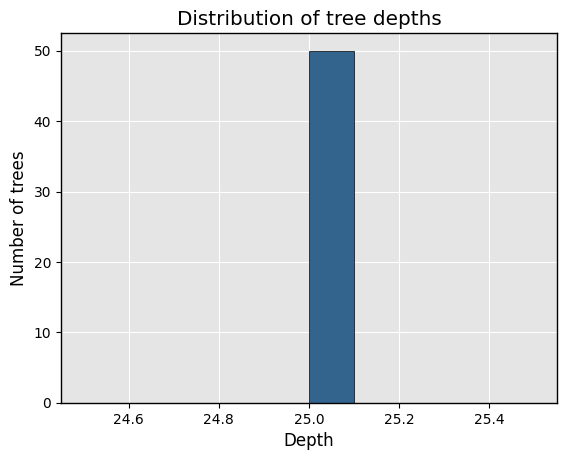

In [ ]:
depths = [t.tree_.max_depth for t in model_cust.estimators_]
plt.hist(depths, bins=10, color=vir_col(0.32), edgecolor="black")
plt.title("Distribution of tree depths")
plt.xlabel("Depth")
plt.ylabel("Number of trees")
plt.show()

In [38]:
customers_showcase_params_rf = pd.read_csv("outputs/customers_recursive_randomforest_grid_small.csv").iloc[1, 0:4].to_dict()
customers_showcase_params_rf["max_depth"] = int(customers_showcase_params_rf["max_depth"])
customers_showcase_params_rf["max_features"] = float(customers_showcase_params_rf["max_features"])

# This gets the best parameters based on the naive grid search for customers only
model_cust_showcase = RandomForestRegressor(**customers_showcase_params_rf, 
                                            n_jobs=4, 
                                            random_state=42,
                                            verbose=0)
model_cust_showcase.fit(recursive_training_df.loc[recursive_training_df["Open"] == 1, cols_to_select_cust], 
                        recursive_training_df.loc[recursive_training_df["Open"] == 1, "Customers"])
gc.collect()

11097

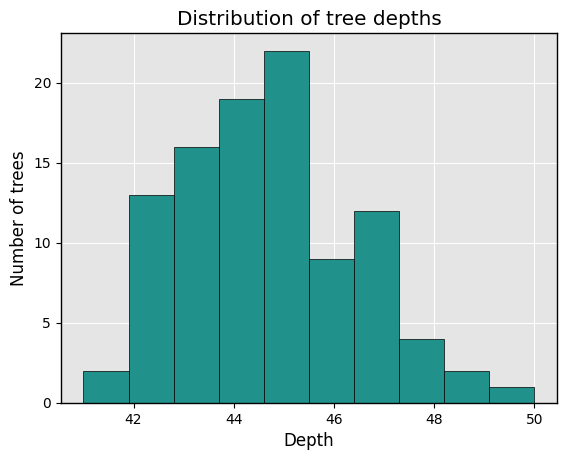

In [41]:
depths = [t.tree_.max_depth for t in model_cust_showcase.estimators_]
plt.hist(depths, bins=10, color=vir_col(0.5), edgecolor="black")
plt.title("Distribution of tree depths")
plt.xlabel("Depth")
plt.ylabel("Number of trees")
plt.show()

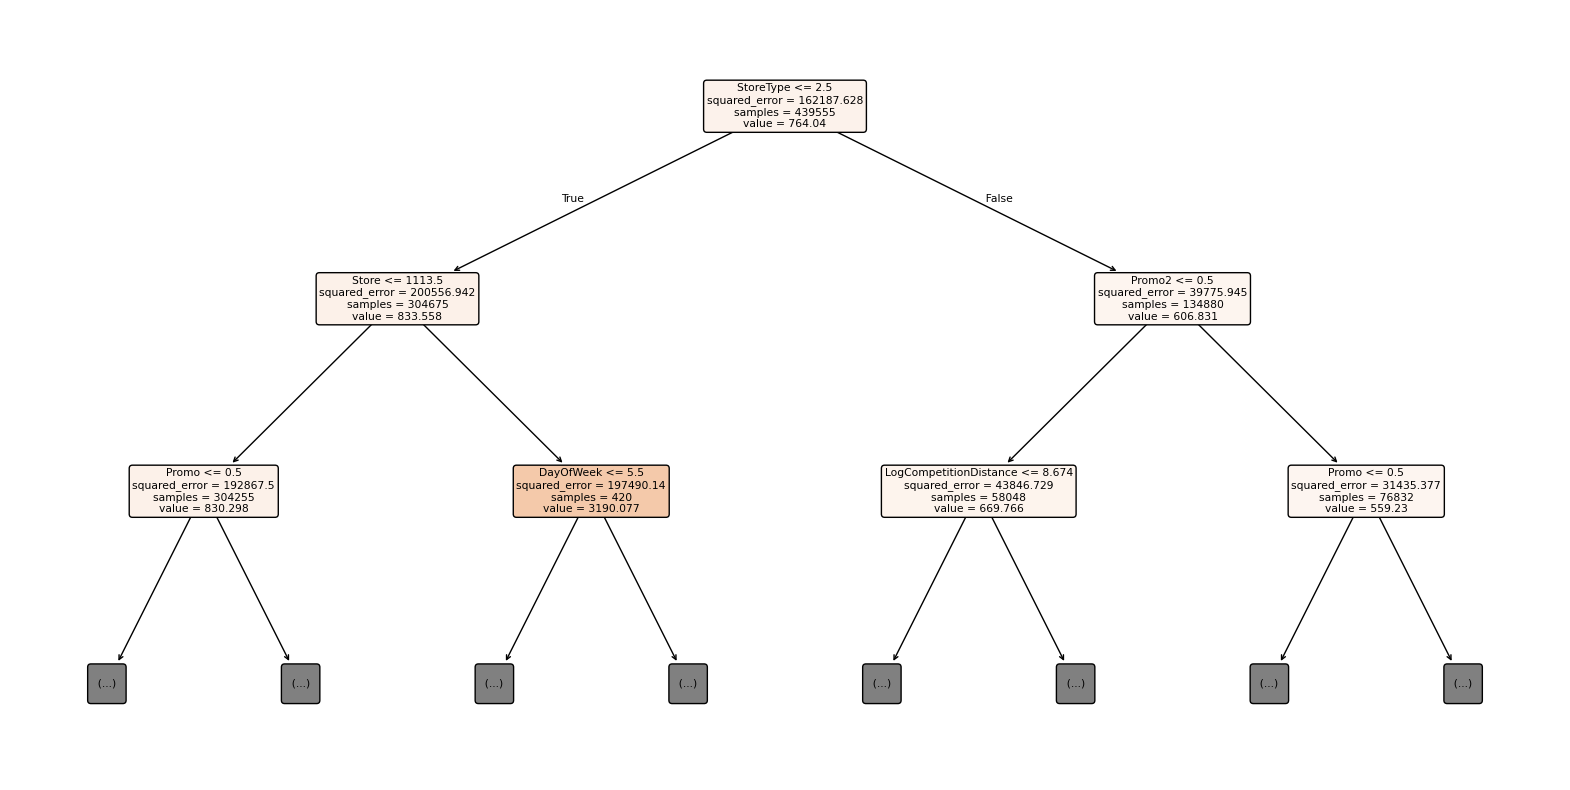

In [17]:
tree = model_cust.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree, 
          feature_names=recursive_training_df.loc[recursive_training_df["Open"] == 1, cols_to_select_cust].columns, 
          filled=True, 
          rounded=True, 
          max_depth=2)  # limit depth for readability
plt.show()

In [42]:
test_cust_preds = model_cust.predict(recursive_test_df.loc[recursive_test_df["Open"] == 1, cols_to_select_cust])
test_cust_rmspe_open = rmspe(recursive_test_df.loc[recursive_test_df["Open"] == 1, "Customers"], test_cust_preds)

print(f"Customers only, open stores RMSPE is: {test_cust_rmspe_open:.4f}.")

#explainer = shap.TreeExplainer(model_cust)

Customers only, open stores RMSPE is: 0.1236.


In [21]:
recursive_test_df.loc[recursive_test_df["Open"] == 0, "Customers"] = 0
recursive_test_df.loc[recursive_test_df["Open"] == 1, "Customers"] = np.round(test_cust_preds)

In [22]:
val_results = recursive_predict_sales_only(
    model_sales, 
    recursive_training_df,
    recursive_test_df,
    cols_to_select_sales
)

score = rmspe(val_results.sort_values(["Store", "Date"])["Sales"], recursive_test_df["Sales"])
print(f"Final test sales RMSPE: {score:.4f}")

Final test sales RMSPE: 0.1406


### LightGBM

In [18]:
def grid_search_log(param_grid, model_type, x_train, y_train, x_val, y_val, n_jobs, verbose = False):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    results_data = []

    for i, params in enumerate(param_combinations):
        model = model_type(
            **params,
            random_state=42,
            n_jobs=n_jobs,
            verbose=0
        )

        model.fit(x_train, y_train)

        y_train_predicted = model.predict(x_train)
        y_val_predicted = model.predict(x_val)
        
        mse_train = mean_squared_error(y_train, y_train_predicted)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_predicted)
        rmspe_train = rmspe(np.expm1(y_train), np.expm1(y_train_predicted))

        mse_val = mean_squared_error(y_val, y_val_predicted)
        rmse_val = mse_val ** 0.5
        r2_val = r2_score(y_val, y_val_predicted)
        rmspe_val = rmspe(np.expm1(y_val), np.expm1(y_val_predicted))

        results_entry = params.copy()
        results_entry["Train_RMSPE"] = rmspe_train
        results_entry["Val_RMSPE"] = rmspe_val

        results_data.append(results_entry)

        if verbose:
            print(f"==== TRAINING ==== ({i+1}/{len(param_combinations)})")
            print(f"Train RMSE: {rmse_train:.2f}")
            print(f"Train R²: {r2_train:.3f}")
            print(f"Train RMSPE: {rmspe_train:.4f} ({rmspe_train*100:.2f}%)")
            print("==== TRAINING ====")
            print()

            print(f"==== VALIDATION ==== ({i+1}/{len(param_combinations)})")
            print(f"Validation RMSE: {rmse_val:.2f}")
            print(f"Validation R²: {r2_val:.3f}")
            print(f"Validation RMSPE: {rmspe_val:.4f} ({rmspe_val*100:.2f}%)")
            print("==== VALIDATION ====")
        else:
            print(f"({i+1}/{len(param_combinations)})")

    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values(by="Val_RMSPE", ascending=True)

    if verbose:
        display(results_df.head(5))

    return results_df

In [19]:
def recursive_predict_sales_only_log(model_sales, train_data, test_data, sales_feats):
    
    working_df = test_data.copy().sort_values(["Date", "Store"])
    
    # Setup History
    req_cols = list(set(sales_feats + ["Store", "Date", "Sales"])) # Ensure Open is here
    history = train_data[req_cols].copy()
    history = history.sort_values(["Store", "Date"])
    
    unique_dates = working_df["Date"].unique()
    unique_dates = np.sort(unique_dates)
    final_predictions = []
    
    for current_date in unique_dates:
        todays_slice = working_df[working_df["Date"] == current_date].copy()
        
        # --- A. CALCULATE LAGS (Unchanged) ---
        active_stores = todays_slice["Store"].unique()
        
        recent_history = history[
            (history["Store"].isin(active_stores)) & 
            (history["Date"] >= current_date - pd.Timedelta(days=15)) &
            (history["Date"] < current_date)
        ]
        
        calc_df = pd.concat([recent_history, todays_slice], axis=0, ignore_index=True)
        calc_df = calc_df.sort_values(["Store", "Date"])
        
        calc_df["SalesLag1"] = calc_df.groupby("Store")["Sales"].shift(1)
        calc_df["SalesLag7"] = calc_df.groupby("Store")["Sales"].shift(7)
        calc_df["RollingMean7"] = calc_df.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
        
        X_today = calc_df[calc_df["Date"] == current_date].copy()
        
        X_today["SalesLag1Available"] = ~X_today["SalesLag1"].isna() * 1
        X_today["SalesLag7Available"] = ~X_today["SalesLag7"].isna() * 1
        X_today["RollingMean7Available"] = ~X_today["RollingMean7"].isna() * 1
        X_today = X_today.fillna(0)
        
        # --- B. PREDICT SALES ---
        X_today_feats = X_today[sales_feats]
        
        # 1. Get Log Predictions
        sales_preds = np.expm1(model_sales.predict(X_today_feats))
        
        if "Open" in X_today.columns:
             sales_preds[X_today["Open"] == 0] = 0
        
        # --- C. UPDATE HISTORY ---
        X_today_result = X_today.copy()
        X_today_result["Sales"] = sales_preds # Now saving REAL numbers
        
        update_packet = X_today_result[req_cols]
        history = pd.concat([history, update_packet], axis=0, ignore_index=True)
        
        final_predictions.append(X_today_result[["Store", "Date", "Sales"]])
        
    final_df = pd.concat(final_predictions, axis=0)
    return final_df

In [ ]:
lgbm_param_grid_cust = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "subsample": [0.6, 0.8, 1],
    "subsample_freq": [1],
    "colsample_bytree": [0.5, 0.8, 1]
}

results_cust = grid_search_log(param_grid=lgbm_param_grid_cust,
                                 model_type=lgb.LGBMRegressor,
                                 x_train=x_train_cust,
                                 y_train=np.log1p(y_train_cust),
                                 x_val=x_val_cust,
                                 y_val=np.log1p(y_val_cust),
                                 n_jobs=5)


In [63]:
results_cust.to_csv("outputs/customers_recursive_lightgbm_grid.csv", index=False)

In [ ]:
lgmb_param_grid_sales = {
    "n_estimators": [3000, 4000, 5000, 6000],
    "learning_rate": [0.1],
    "num_leaves": [63],
    "subsample": [0.8, 0.9],
    "subsample_freq": [1],
    "colsample_bytree": [1]
}

results_sales = grid_search_log(param_grid=lgmb_param_grid_sales,
                                model_type=lgb.LGBMRegressor,
                                x_train=x_train_sales,
                                y_train=np.log1p(y_train_sales),
                                x_val=x_val_sales,
                                y_val=np.log1p(y_val_sales),
                                n_jobs=5)

In [ ]:
results_sales.to_csv("outputs/sales_recursive_lightgbm_grid.csv", index=False)

In [5]:
customers_best_params_lgbm = pd.read_csv("outputs/customers_recursive_lightgbm_grid.csv").iloc[0, 0:6].to_dict()
sales_best_params_lgbm = pd.read_csv("outputs/sales_recursive_lightgbm_grid.csv").iloc[0, 0:6].to_dict()

for params in (customers_best_params_lgbm, sales_best_params_lgbm):
    for key in params.keys():
        if key not in ("learning_rate", "colsample_bytree", "subsample"):
            params[key] = int(params[key])

display(customers_best_params_lgbm)
display(sales_best_params_lgbm)

{'n_estimators': 4000,
 'learning_rate': 0.1,
 'num_leaves': 63,
 'subsample': 0.8,
 'subsample_freq': 1,
 'colsample_bytree': 1.0}

{'n_estimators': 6000,
 'learning_rate': 0.1,
 'num_leaves': 63,
 'subsample': 0.9,
 'subsample_freq': 1,
 'colsample_bytree': 1.0}

In [20]:
recursive_train_set_lgbm = train_set.copy()
recursive_validation_set_lgbm = validation_set.copy()

recursive_training_df_lgbm = pd.concat([recursive_train_set_lgbm, 
                                        recursive_validation_set_lgbm], axis = 0).sort_values(["Store", "Date"])
recursive_training_df_lgbm["Sales"] = np.log1p(recursive_training_df_lgbm["Sales"])
recursive_training_df_lgbm["Customers"] = np.log1p(recursive_training_df_lgbm["Customers"])

In [21]:
# This gets the best parameters based on the naive grid search for customers only
model_cust = lgb.LGBMRegressor(**customers_best_params_lgbm, 
                               n_jobs=4, 
                               random_state=42,
                               verbose=0)
model_cust.fit(recursive_training_df_lgbm.loc[recursive_training_df_lgbm["Open"] == 1, cols_to_select_cust], 
               recursive_training_df_lgbm.loc[recursive_training_df_lgbm["Open"] == 1, "Customers"])
gc.collect()

# This gets the best parameters with actual sales values
model_sales = lgb.LGBMRegressor(**sales_best_params_lgbm, 
                               n_jobs=4, 
                               random_state=42,
                               verbose=0)
model_sales.fit(recursive_training_df_lgbm.loc[recursive_training_df_lgbm["Open"] == 1, cols_to_select_sales], 
                recursive_training_df_lgbm.loc[recursive_training_df_lgbm["Open"] == 1, "Sales"])
gc.collect()

48

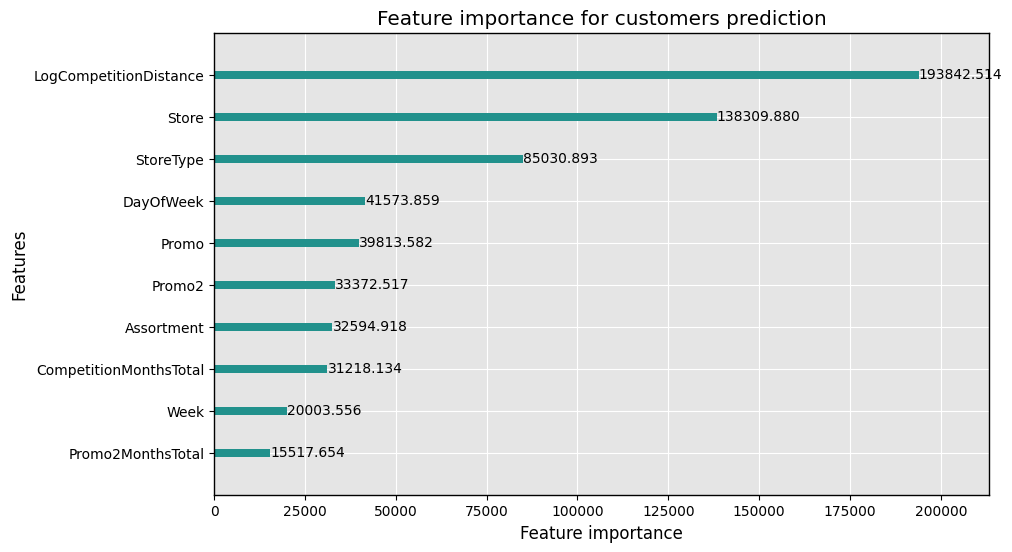

In [40]:
lgb.plot_importance(model_cust, 
                    figsize=(10, 6), 
                    max_num_features=10, 
                    color = vir_col(0.5),
                    importance_type="gain")
plt.title("Feature importance for customers prediction")
plt.show()

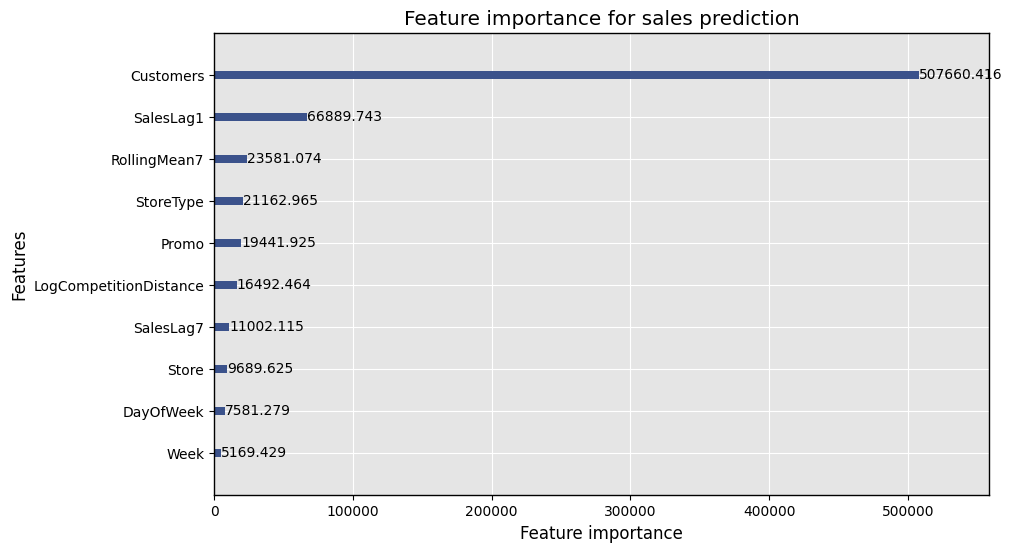

In [41]:
lgb.plot_importance(model_sales, 
                    figsize=(10, 6), 
                    max_num_features=10, 
                    color=vir_col(0.25),
                    importance_type="gain")
plt.title("Feature importance for sales prediction")
plt.show()

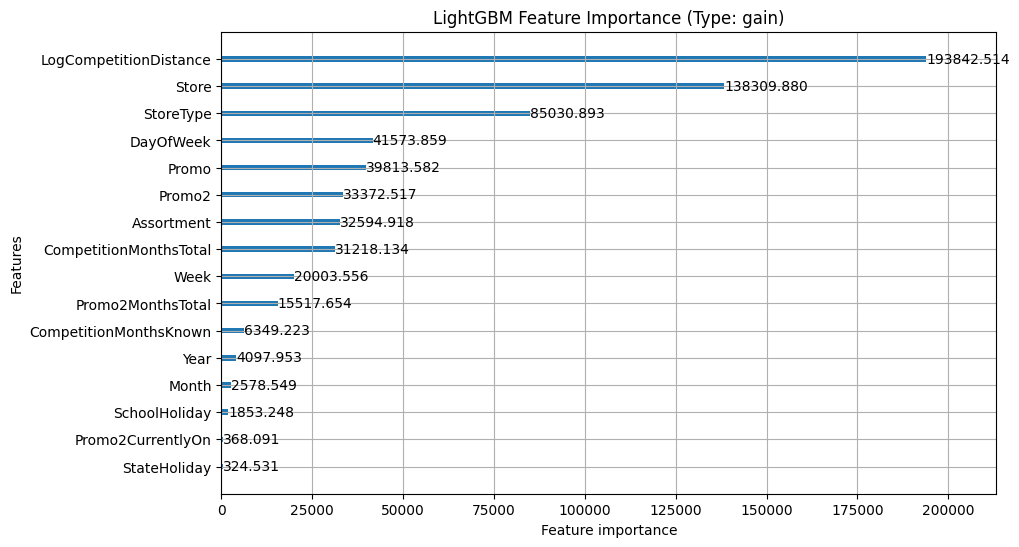

In [23]:
lgb.plot_importance(model_cust, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance (Type: gain)")
plt.show()

In [76]:
recursive_test_df_lgbm = test_set.copy().sort_values(["Store", "Date"])

test_cust_preds = model_cust.predict(recursive_test_df_lgbm.loc[recursive_test_df_lgbm["Open"] == 1, cols_to_select_cust])
test_cust_rmspe_open = rmspe(recursive_test_df_lgbm.loc[recursive_test_df_lgbm["Open"] == 1, "Customers"], 
                             np.expm1(test_cust_preds))

print(f"Customers only, open stores RMSPE is: {test_cust_rmspe_open:.4f}.")
 
recursive_test_df_lgbm.loc[recursive_test_df_lgbm["Open"] == 0, "Customers"] = 0
recursive_test_df_lgbm.loc[recursive_test_df_lgbm["Open"] == 1, "Customers"] = test_cust_preds

Customers only, open stores RMSPE is: 0.1022.


/tmp/ipykernel_41946/2232175092.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.39977089 6.30296022 6.2954967  ... 6.1554073  6.23918991 6.24709461]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  recursive_test_df_lgbm.loc[recursive_test_df_lgbm["Open"] == 1, "Customers"] = test_cust_preds


In [77]:
test_results = recursive_predict_sales_only_log(
    model_sales, 
    recursive_training_df_lgbm,
    recursive_test_df_lgbm,
    cols_to_select_sales
)

score = rmspe(test_results.sort_values(["Store", "Date"])["Sales"] * 1.02, recursive_test_df_lgbm["Sales"])
print(f"Final test sales RMSPE: {score:.4f}")

Final test sales RMSPE: 0.1235


### Neural Networks

In [244]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [245]:
dataset_nn = pd.read_pickle("train_clean.pkl")
dataset_nn = dataset_nn.sort_values(by=["Store", "Date"]).reset_index(drop=True)

In [246]:
# ===== CREATING LAGS AND ROLLING MEANS =====
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dataset_nn["SalesLag1"] = dataset_nn.groupby("Store")["Sales"].shift(1)
    dataset_nn["SalesLag7"] = dataset_nn.groupby("Store")["Sales"].shift(7)
    dataset_nn["RollingMean7"] = dataset_nn.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
    first_idx_per_store = dataset_nn.groupby("Store").head(1).index
    dataset_nn.loc[first_idx_per_store, "RollingMean7"] = float("nan")
    dataset_nn["SalesLag1Available"] = ~dataset_nn["SalesLag1"].isna() * 1
    dataset_nn["SalesLag7Available"] = ~dataset_nn["SalesLag7"].isna() * 1
    dataset_nn["RollingMean7Available"] = ~dataset_nn["RollingMean7"].isna() * 1

    dataset_nn.loc[:, dataset_nn.isna().sum() != 0] = dataset_nn.loc[:, dataset_nn.isna().sum() != 0].fillna(0)

In [247]:
# ===== TRAIN, VALIDATION, TEST SPLITTING =====

days_amount = (dataset_nn.Date.iloc[-1,] - dataset_nn.Date.iloc[0,])
test_split_time = dataset_nn.Date.iloc[-1,] - pd.Timedelta(days=int(days_amount.days*0.05 - 1))
validation_split_time = dataset_nn.Date.iloc[-1,] - pd.Timedelta(days=int(days_amount.days*0.1 + 1))

train_set_nn_clean = dataset_nn[dataset_nn.Date < validation_split_time]
validation_set_nn_clean = dataset_nn[(dataset_nn.Date >= validation_split_time) & (dataset_nn.Date < test_split_time)]
test_set_nn_clean = dataset_nn[dataset_nn.Date >= test_split_time]

In [248]:
embed_cols = ["Store"] 
dummify_cols = ["StateHoliday", "StoreType", "Assortment", "DayOfWeek"] 
# num_cols have to be scaled (standardized to mean 0 and std of 1)
num_cols = [
    "SalesLag1", "SalesLag7", "RollingMean7", 
    "LogCompetitionDistance", 
    "CompetitionMonthsTotal", 
    "Promo2MonthsTotal",
    "Year", "Month", "Week"
]

binary_cols = [
    "Open", "Promo", "SchoolHoliday", "Promo2", "Promo2CurrentlyOn", "CompetitionMonthsKnown",
    "SalesLag1Available", "SalesLag7Available", "RollingMean7Available"
]

In [249]:
# A ===== LOG TRANSFORMING =====
train_set_nn = train_set_nn_clean.copy()
validation_set_nn = validation_set_nn_clean.copy()
test_set_nn = test_set_nn_clean.copy()

for df_nn in (train_set_nn, validation_set_nn, test_set_nn):
    df_nn["Sales_log"] = np.log1p(df_nn["Sales"])
    df_nn["Customers_log"] = np.log1p(df_nn["Customers"])

# B ===== ONE HOT ENCODING =====
train_set_nn = pd.get_dummies(train_set_nn, columns=dummify_cols, dtype=float)
validation_set_nn = pd.get_dummies(validation_set_nn, columns=dummify_cols, dtype=float)
test_set_nn = pd.get_dummies(test_set_nn, columns=dummify_cols, dtype=float)

train_cols = train_set_nn.columns
validation_set_nn = validation_set_nn.reindex(columns=train_cols, fill_value=0)
test_set_nn = test_set_nn.reindex(columns=train_cols, fill_value=0)

new_one_hot_features = [c for c in train_set_nn.columns if any(x in c for x in dummify_cols)]
all_binary_cols = binary_cols + new_one_hot_features

# C ===== SCALING NUMERICAL VARIABLES =====
scaler = StandardScaler()
cols_to_scale = num_cols + ['Customers_log', 'Sales_log']

# Scale (Overwrites columns in place)
train_set_nn[cols_to_scale] = scaler.fit_transform(train_set_nn[cols_to_scale])
validation_set_nn[cols_to_scale] = scaler.transform(validation_set_nn[cols_to_scale])
test_set_nn[cols_to_scale] = scaler.transform(test_set_nn[cols_to_scale])

# Save scaler stats for recursion later
cust_idx = cols_to_scale.index('Customers_log')
cust_mean = scaler.mean_[cust_idx]
cust_scale = scaler.scale_[cust_idx]

sales_idx = cols_to_scale.index('Sales_log')
sales_mean = scaler.mean_[sales_idx]
sales_scale = scaler.scale_[sales_idx]

# Define columns to be ignored by both models
lag_cols_to_exclude = [
    "SalesLag1", "SalesLag7", "RollingMean7",
    "SalesLag1Available", "SalesLag7Available", "RollingMean7Available"
]

# 1. FEATURES FOR CUSTOMER MODEL
scaled_cols_for_input = [c for c in cols_to_scale if c not in ['Customers_log', 'Sales_log']]
binary_cols_for_input = all_binary_cols
cust_input_cols = [c for c in (scaled_cols_for_input + binary_cols_for_input) if c not in lag_cols_to_exclude]

# 2. FEATURES FOR SALES MODEL (Includes Customers_log and Lags, but No Sales_log)
sales_input_cols = [c for c in cols_to_scale if c != 'Sales_log'] + all_binary_cols

# D ===== PREPARE DICTIONARY =====
def prepare_inputs_cust(df):
    X = {
        "input_Store": df['Store'].values.astype(int),
        "input_numerical": df[cust_input_cols].values.astype(float)
    }
    return X

def prepare_inputs_sales(df):
    X = {
        "input_Store": df['Store'].values.astype(int),
        "input_numerical": df[sales_input_cols].values.astype(float)
    }
    return X

# Inputs for Customer Model
X_train_cust = prepare_inputs_cust(train_set_nn)
X_val_cust = prepare_inputs_cust(validation_set_nn)
X_test_cust = prepare_inputs_cust(test_set_nn)

# Inputs for Sales Model
X_train_sales = prepare_inputs_sales(train_set_nn)
X_val_sales = prepare_inputs_sales(validation_set_nn)
X_test_sales = prepare_inputs_sales(test_set_nn)

In [257]:
def build_embedding_model(num_numerical_features, learning_rate=0.001):
    store_input = Input(shape=(1,), name="input_Store")
    
    # Shrinking a 1115 dimension spaces to a different vectors in R^10
    store_embed = Embedding(input_dim=1116, output_dim=10, name="embed_Store")(store_input)
    store_embed = Flatten()(store_embed)

    num_input = Input(shape=(num_numerical_features,), name="input_numerical")
    merged = Concatenate()([store_embed, num_input])
    
    x = Dense(2000, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[store_input, num_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    return model

In [258]:
num_feats_cust = X_train_cust['input_numerical'].shape[1]
model_cust = build_embedding_model(num_numerical_features=num_feats_cust)

y_train_cust = train_set_nn['Customers_log'].values
y_val_cust = validation_set_nn['Customers_log'].values

callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    )
]

history_cust = model_cust.fit(
    X_train_cust, y_train_cust,
    validation_data=(X_val_cust, y_val_cust),
    epochs=50, 
    batch_size=512,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - loss: 0.0141 - val_loss: 0.0058
Epoch 2/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 3/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 4/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 5/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 87s 49ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 6/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 7/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 8/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 9/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 86s 48ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 10/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 11/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 12

In [ ]:
is_open = train_set_nn['Open'].values
mask = is_open == 1

y_pred_cust = np.expm1((model_cust.predict(X_train_cust, verbose=0).flatten() * cust_scale) + cust_mean)
y_true_cust = train_set_nn['Customers'].values
score_cust = rmspe(y_true_cust[mask], y_pred_cust[mask])

print(f"Customer Model RMSPE: {score_cust:.4f}")

Customer Model RMSPE: 0.4862


In [256]:
is_open = validation_set_nn['Open'].values
mask = is_open == 1

y_pred_cust = np.expm1((model_cust.predict(X_val_cust, verbose=0).flatten() * cust_scale) + cust_mean)
y_true_cust = validation_set_nn['Customers'].values
score_cust = rmspe(y_true_cust[mask], y_pred_cust[mask])

print(f"Customer Model valid RMSPE: {score_cust:.4f}")

results_df = pd.DataFrame({
    'Store': validation_set_nn['Store'],
    'Date': validation_set_nn['Date'],
    'Open': validation_set_nn['Open'],
    'Actual_Customers': y_true_cust,
    'Predicted_Customers': np.round(y_pred_cust)
})

print("\nSample Predictions:")
display(results_df[results_df['Open'] == 1].head(5))



is_open = test_set_nn['Open'].values
mask = is_open == 1

y_pred_cust = np.expm1((model_cust.predict(X_test_cust, verbose=0).flatten() * cust_scale) + cust_mean)
y_true_cust = test_set_nn['Customers'].values
score_cust = rmspe(y_true_cust[mask], y_pred_cust[mask])

print(f"Customer Model test RMSPE: {score_cust:.4f}")

Customer Model valid RMSPE: 0.1162

Sample Predictions:


,Store,Date,Open,Actual_Customers,Predicted_Customers
846,1,2015-04-27,1,574,577.0
847,1,2015-04-28,1,552,547.0
848,1,2015-04-29,1,579,527.0
849,1,2015-04-30,1,650,535.0
851,1,2015-05-02,1,653,571.0


Customer Model test RMSPE: 0.2309


### Sales

In [ ]:
num_feats_cust = X_train['input_numerical'].shape[1]
model_cust = build_embedding_model(num_numerical_features=num_feats_cust)

y_train_cust = train_set_nn['Customers_log'].values
y_val_cust = validation_set_nn['Customers_log'].values

callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    )
]

history_cust = model_cust.fit(
    X_train, y_train_cust,
    validation_data=(X_val, y_val_cust),
    epochs=50, 
    batch_size=512,
    callbacks=callbacks_list,
    verbose=1
)

In [ ]:
num_feats_sales = X_train['input_numerical'].shape[1]
model_sales = build_embedding_model(num_numerical_features=num_feats_sales)

y_train_sales = train_set_nn['Sales_log'].values
y_val_sales = validation_set_nn['Sales_log'].values

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history_sales = model_sales.fit(
    X_train, y_train_sales,
    validation_data=(X_val, y_val_sales),
    epochs=50,
    batch_size=512,
    callbacks=callbacks_list,
    verbose=1
)

is_open = train_set_nn['Open'].values
mask = is_open == 1

y_pred_sales = np.expm1((model_sales.predict(X_train, verbose=0).flatten() * sales_scale) + sales_mean)
y_true_sales = train_set_nn['Sales'].values
score_sales = rmspe(y_true_sales[mask], y_pred_sales[mask])

print(f"Sales Model RMSPE (Train): {score_sales:.4f}")


is_open = test_set_nn['Open'].values
mask = is_open == 1

y_pred_sales = np.expm1((model_sales.predict(X_test, verbose=0).flatten() * sales_scale) + sales_mean)
y_true_sales = test_set_nn['Sales'].values
score_sales = rmspe(y_true_sales[mask], y_pred_sales[mask])

print(f"Sales Model RMSPE (Test): {score_sales:.4f}")


is_open = validation_set_nn['Open'].values
mask = is_open == 1

y_pred_sales = np.expm1((model_sales.predict(X_val, verbose=0).flatten() * sales_scale) + sales_mean)
y_true_sales = validation_set_nn['Sales'].values
score_sales = rmspe(y_true_sales[mask], y_pred_sales[mask])

print(f"Sales Model RMSPE (Validation): {score_sales:.4f}")

results_df_sales = pd.DataFrame({
    'Store': validation_set_nn['Store'],
    'Date': validation_set_nn['Date'],
    'Open': validation_set_nn['Open'],
    'Actual_Sales': y_true_sales,
    'Predicted_Sales': np.round(y_pred_sales)
})

print("Sample Sales Predictions:")
display(results_df_sales[results_df_sales['Open'] == 1].head(5))

Epoch 1/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0230 - val_loss: 0.0040
Epoch 2/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 3/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 4/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 5/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 6/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 7/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 8/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 9/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 10/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 11/50
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 12/50
1778/1778 ━━━━━━━

,Store,Date,Open,Actual_Sales,Predicted_Sales
846,1,2015-04-27,1,5575,5727.0
847,1,2015-04-28,1,5199,4952.0
848,1,2015-04-29,1,5775,5083.0
849,1,2015-04-30,1,6228,5095.0
851,1,2015-05-02,1,5850,5813.0


In [ ]:
def recursive_predict_neural_net(model_cust, model_sales, train_data, test_data, 
                                 numeric_cols, binary_cols, scaler, 
                                 cust_col_name='Customers_log', sales_col_name='Sales_log'):
    
    # 1. SETUP
    working_df = test_data.copy().sort_values(['Date', 'Store'])
    
    # Get the list of columns used as input for the CUSTOMERS model
    # (Numeric_cols, but excluding the target) + Binary_cols
    cust_input_cols = [c for c in numeric_cols if c != cust_col_name] + binary_cols
    
    # Get the list of columns used as input for the SALES model
    # (Numeric_cols, INCLUDING the target) + Binary_cols
    sales_input_cols = numeric_cols + binary_cols
    
    # History must contain base features + real Sales/Customers
    req_cols = list(set([c for c in numeric_cols if c not in [cust_col_name, sales_col_name]] + binary_cols + ['Store', 'Date', 'Sales', 'Customers', 'Open']))
    history = train_data[req_cols].copy().sort_values(['Store', 'Date'])
    
    unique_dates = np.sort(working_df['Date'].unique())
    final_predictions = []
    
    # Find scaler stats for inverse transform
    # Assuming 'Customers_log' was the LAST column in numeric_cols/cols_to_scale during training
    # This logic assumes you passed the global scaler that included Customers_log
    
    print(f"Starting loop for {len(unique_dates)} days...")
    
    lag_cols = ['SalesLag1', 'SalesLag7', 'RollingMean7']

    for current_date in unique_dates:
        todays_slice = working_df[working_df['Date'] == current_date].copy()
        
        # --- A. CALCULATE LAGS (Standard) ---
        active_stores = todays_slice['Store'].unique()
        recent_history = history[
            (history['Store'].isin(active_stores)) & 
            (history['Date'] >= current_date - pd.Timedelta(days=8)) & # Only need up to 7 days
            (history['Date'] < current_date)
        ]
        
        # NOTE: Using a simple merge or function application is less error prone than concat/shift
        # For simplicity, we'll keep the concat/shift but acknowledge the memory overhead
        calc_df = pd.concat([recent_history, todays_slice], axis=0, ignore_index=True)
        calc_df = calc_df.sort_values(['Store', 'Date'])
        
        # Recalculate lags using 'Sales' from history/predictions
        calc_df["SalesLag1"] = calc_df.groupby("Store")["Sales"].shift(1)
        calc_df["SalesLag7"] = calc_df.groupby("Store")["Sales"].shift(7)
        calc_df["RollingMean7"] = calc_df.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
        
        X_today = calc_df[calc_df['Date'] == current_date].copy()
        
        # Fill NaNs for lags with 0 (and set availability flags if needed)
        X_today[lag_cols] = X_today[lag_cols].fillna(0)
        
        # 🛑 FIX 2: Apply log1p transformation to lagged features
        X_today[lag_cols] = np.log1p(X_today[lag_cols])
        
        # --- B. SCALE INPUTS ---
        # Add placeholder columns for targets expected by the scaler
        X_today[cust_col_name] = 0.0
        X_today[sales_col_name] = 0.0

        # Scale EVERYTHING using the global scaler
        # We must scale ALL columns in the original numeric_cols list
        X_today_scaled = X_today.copy()
        # This will scale all features correctly, including the new log-lag features
        X_today_scaled[numeric_cols] = scaler.transform(X_today[numeric_cols])
        
        # --- C. PREDICT CUSTOMERS ---
        # Build the inputs using the explicit column list for the customer model
        inputs_cust = {
            "input_Store": X_today['Store'].values.astype(int),
            "input_numerical": X_today_scaled[cust_input_cols].values.astype(float)
        }
        
        # Predict Log Customers (Output is the SCALED log value)
        pred_cust_log_scaled = model_cust.predict(inputs_cust, verbose=0).flatten()
        
        # --- D. INJECT PREDICTIONS FOR SALES MODEL ---
        # 🛑 FIX 1: Insert the predicted SCALED log customers directly into the scaled features
        X_today_scaled[cust_col_name] = pred_cust_log_scaled
        
        # Build the inputs using the explicit column list for the sales model
        inputs_sales = {
            "input_Store": X_today['Store'].values.astype(int),
            "input_numerical": X_today_scaled[sales_input_cols].values.astype(float)
        }
        
        # --- E. PREDICT SALES ---
        # Predict Log Sales (Output is the SCALED log value)
        pred_sales_log_scaled = model_sales.predict(inputs_sales, verbose=0).flatten()
        
        # --- F. INVERSE & UPDATE ---
        
        # 1. Unscale the predictions from the scaled log domain
        # The mean/scale of Sales_log must be extracted from the scaler object
        # Assuming Sales_log is the first column in the scaler for simplicity, 
        # but you should have saved the Sales_log mean/scale like you did for Customers_log
        
        # Here we use cust_mean/cust_scale for the customer prediction:
        cust_mean = scaler.mean_[numeric_cols.index(cust_col_name)]
        cust_scale = scaler.scale_[numeric_cols.index(cust_col_name)]
        
        # Unscale Customers:
        pred_cust_log_unscaled = pred_cust_log_scaled * cust_scale + cust_mean
        pred_cust_real = np.expm1(pred_cust_log_unscaled)
        pred_cust_real = np.maximum(pred_cust_real, 0)
        
        # Unscale Sales: (You'll need the correct mean/scale for Sales_log here)
        # For this example, let's assume we retrieve sales_mean/sales_scale similarly
        sales_mean = scaler.mean_[numeric_cols.index(sales_col_name)]
        sales_scale = scaler.scale_[numeric_cols.index(sales_col_name)]
        
        pred_sales_log_unscaled = pred_sales_log_scaled * sales_scale + sales_mean
        pred_sales_real = np.expm1(pred_sales_log_unscaled)
        pred_sales_real = np.maximum(pred_sales_real, 0)
        
        # Apply Open status
        if 'Open' in X_today.columns:
            is_open = X_today['Open'].values
            pred_sales_real[is_open == 0] = 0
            pred_cust_real[is_open == 0] = 0
            
        X_today_result = X_today.copy()
        X_today_result['Sales'] = pred_sales_real
        X_today_result['Customers'] = pred_cust_real
        
        # Update history with the predicted REAL values
        update_packet = X_today_result[req_cols]
        history = pd.concat([history, update_packet], axis=0, ignore_index=True)
        
        final_predictions.append(X_today_result[['Store', 'Date', 'Sales', 'Customers']])
        
    return pd.concat(final_predictions, axis=0)

In [148]:
def recursive_predict_neural_net(model_cust, model_sales, train_data, test_data, 
                                 numeric_cols, binary_cols, scaler, 
                                 cust_mean, cust_scale):
    
    # 1. SETUP
    working_df = test_data.copy().sort_values(['Date', 'Store'])
    
    # History needs REAL numbers (from train_data, NOT train_set_nn)
    # We need: Sales, Customers, Store, Date, Open
    req_cols = list(set(numeric_cols + binary_cols + ['Store', 'Date', 'Sales', 'Customers', 'Open']))
    
    # Clean history to ensure no extra scaled columns interfere
    history = train_data[req_cols].copy().sort_values(['Store', 'Date'])
    
    unique_dates = np.sort(working_df['Date'].unique())
    final_predictions = []
    
    # Find index of 'Customers_log' so we can inject predictions
    # We assume 'Customers_log' is the LAST column in numeric_cols if you appended it
    # But let's be safe and find the index
    try:
        cust_col_idx = numeric_cols.index('Customers_log')
    except ValueError:
        # If 'Customers_log' isn't in numeric_cols, we have a mismatch
        print("Error: 'Customers_log' must be in numeric_cols list!")
        return None
        
    print(f"Starting loop for {len(unique_dates)} days...")
    
    for current_date in unique_dates:
        todays_slice = working_df[working_df['Date'] == current_date].copy()
        
        # --- A. CALCULATE LAGS (Standard) ---
        active_stores = todays_slice['Store'].unique()
        recent_history = history[
            (history['Store'].isin(active_stores)) & 
            (history['Date'] >= current_date - pd.Timedelta(days=15)) &
            (history['Date'] < current_date)
        ]
        
        calc_df = pd.concat([recent_history, todays_slice], axis=0, ignore_index=True)
        calc_df = calc_df.sort_values(['Store', 'Date'])
        
        calc_df["SalesLag1"] = calc_df.groupby("Store")["Sales"].shift(1)
        calc_df["SalesLag7"] = calc_df.groupby("Store")["Sales"].shift(7)
        calc_df["RollingMean7"] = calc_df.groupby("Store")["Sales"].rolling(7).mean().shift(1).reset_index(level=0, drop=True)
        
        X_today = calc_df[calc_df['Date'] == current_date].copy()
        
        # Critical: Fill NaNs for lags (using 0 is safe for lags)
        # Note: We don't have 'Customers_log' calculated yet, so we ignore it for now
        lag_cols = ['SalesLag1', 'SalesLag7', 'RollingMean7']
        X_today[lag_cols] = X_today[lag_cols].fillna(0)
        
        # --- B. SCALE INPUTS ---
        # We need to log-transform Customers to create the placeholder column
        # (Even though we predict it, the scaler expects the column to exist)
        X_today['Customers_log'] = 0 # Placeholder
        
        # Scale EVERYTHING using the global scaler
        # This scales the Lags correctly, and puts junk in 'Customers_log' (which we will fix)
        X_today_scaled = X_today.copy()
        X_today_scaled[numeric_cols] = scaler.transform(X_today[numeric_cols])
        
        # --- C. PREDICT CUSTOMERS ---
        # input_numerical MUST exclude the target column 'Customers_log'
        # We use the same filtering logic as training
        cust_input_data = X_today_scaled[numeric_cols].values.copy()
        # Remove the Customer column from the input matrix for Model A
        cust_input_data = np.delete(cust_input_data, cust_col_idx, axis=1)
        
        # Combine with binaries
        # (This is tricky to align perfectly with the training dict, so let's use the explicit column list method)
        
        # SAFER METHOD: Re-construct inputs explicitly
        cust_inputs_explicit = [c for c in numeric_cols if c != 'Customers_log'] + binary_cols
        
        inputs_cust = {
            "input_Store": X_today['Store'].values.astype(int),
            "input_numerical": X_today_scaled[cust_inputs_explicit].values.astype(float)
        }
        
        # Predict Log Customers
        pred_cust_log = model_cust.predict(inputs_cust, verbose=0).flatten()
        
        # --- D. INJECT PREDICTIONS FOR SALES MODEL ---
        # 1. Scale the predicted log customers manually
        # (Value - Mean) / Scale
        pred_cust_scaled = (pred_cust_log - cust_mean) / cust_scale
        
        # 2. Insert into the scaled matrix for Model B
        # Model B expects ALL numeric cols including Customers
        sales_inputs_explicit = numeric_cols + binary_cols
        
        # We update the dataframe column
        X_today_scaled['Customers_log'] = pred_cust_scaled
        
        inputs_sales = {
            "input_Store": X_today['Store'].values.astype(int),
            "input_numerical": X_today_scaled[sales_inputs_explicit].values.astype(float)
        }
        
        # --- E. PREDICT SALES ---
        pred_sales_log = model_sales.predict(inputs_sales, verbose=0).flatten()
        
        # --- F. INVERSE & UPDATE ---
        pred_sales_real = np.expm1(pred_sales_log)
        pred_sales_real = np.maximum(pred_sales_real, 0)
        
        pred_cust_real = np.expm1(pred_cust_log)
        pred_cust_real = np.maximum(pred_cust_real, 0)
        
        if 'Open' in X_today.columns:
            pred_sales_real[X_today['Open'] == 0] = 0
            pred_cust_real[X_today['Open'] == 0] = 0
            
        X_today_result = X_today.copy()
        X_today_result['Sales'] = pred_sales_real
        X_today_result['Customers'] = pred_cust_real
        
        update_packet = X_today_result[req_cols]
        history = pd.concat([history, update_packet], axis=0, ignore_index=True)
        
        final_predictions.append(X_today_result[['Store', 'Date', 'Sales', 'Customers']])
        
    return pd.concat(final_predictions, axis=0)

# RUN IT
nn_results = recursive_predict_neural_net(
    model_cust=model_cust,
    model_sales=model_sales,
    train_data=train_set, # RAW DATA
    test_data=test_set,   # RAW DATA
    numeric_cols=cols_to_scale,
    binary_cols=all_binary_cols,
    scaler=scaler,
    cust_mean=cust_mean,
    cust_scale=cust_scale
)

# EVALUATE
score = rmspe(test_set['Sales'], nn_results.sort_values(['Store', 'Date'])['Sales'])
print(f"FINAL NEURAL NET SCORE: {score:.4f}")

KeyError: "['StoreType_a', 'DayOfWeek_1', 'StoreType_b', 'StateHoliday_0', 'DayOfWeek_6', 'StoreType_c', 'DayOfWeek_4', 'StateHoliday_b', 'DayOfWeek_5', 'DayOfWeek_2', 'DayOfWeek_7', 'DayOfWeek_3', 'Customers_log', 'StateHoliday_a', 'Assortment_a', 'Assortment_c', 'StateHoliday_c', 'Assortment_b', 'StoreType_d'] not in index"

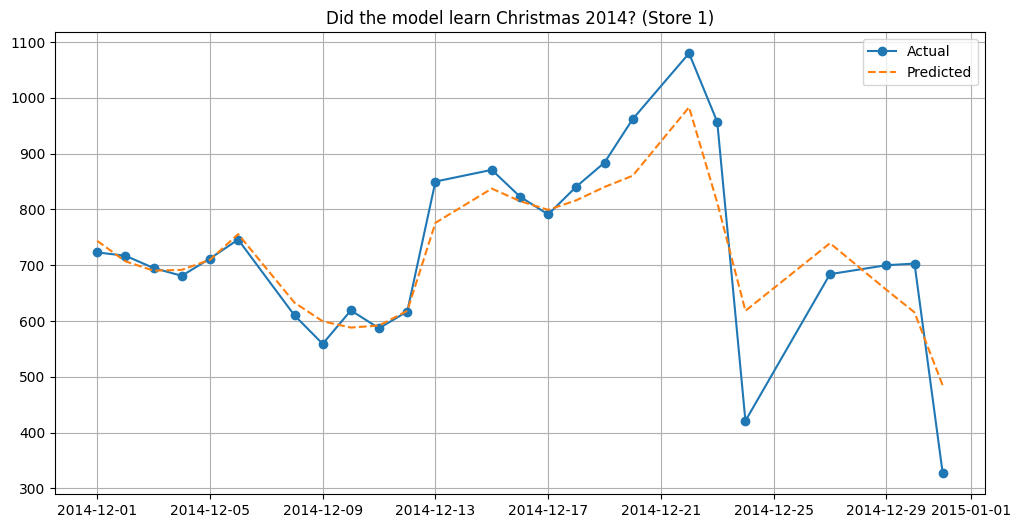

In [ ]:
import matplotlib.pyplot as plt

parameters_cust = {
    "n_estimators": 200,
    "max_depth": 50,
    "max_samples": 0.6,
    "max_features": 0.5
    #"min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    #"min_samples_leaf": [1, 2, 4]     # Minimum samples at a leaf node
}

model_cust = RandomForestRegressor(**parameters_cust, 
                                    n_jobs=8, 
                                    random_state=42,
                                    verbose=0)
model_cust.fit(x_train_cust, y_train_cust)

# 1. Predict on the Training Set (Yes, checking training score is useful here!)
# Note: Ensure x_train has the lags/customers if that"s the model you are checking
train_preds = model_cust.predict(x_train_cust) 

# 2. Add prediction to a temporary dataframe
check_df = train_set.copy()
check_df["Predicted_Customers"] = train_preds

# 3. Filter for December 2014 (The "Hard Exam" inside the training set)
dec_2014 = check_df[
    (check_df["Date"] >= "2014-12-01") & 
    (check_df["Date"] <= "2014-12-31") & 
    (check_df["Store"] == 1) # Look at just one store to minimize noise
]

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(dec_2014["Date"], dec_2014["Customers"], label="Actual", marker="o")
plt.plot(dec_2014["Date"], dec_2014["Predicted_Customers"], label="Predicted", linestyle="--")
plt.title("Did the model learn Christmas 2014? (Store 1)")
plt.legend()
plt.grid(True)
plt.show()

Training Customer Model...
Predicting on Validation Data...


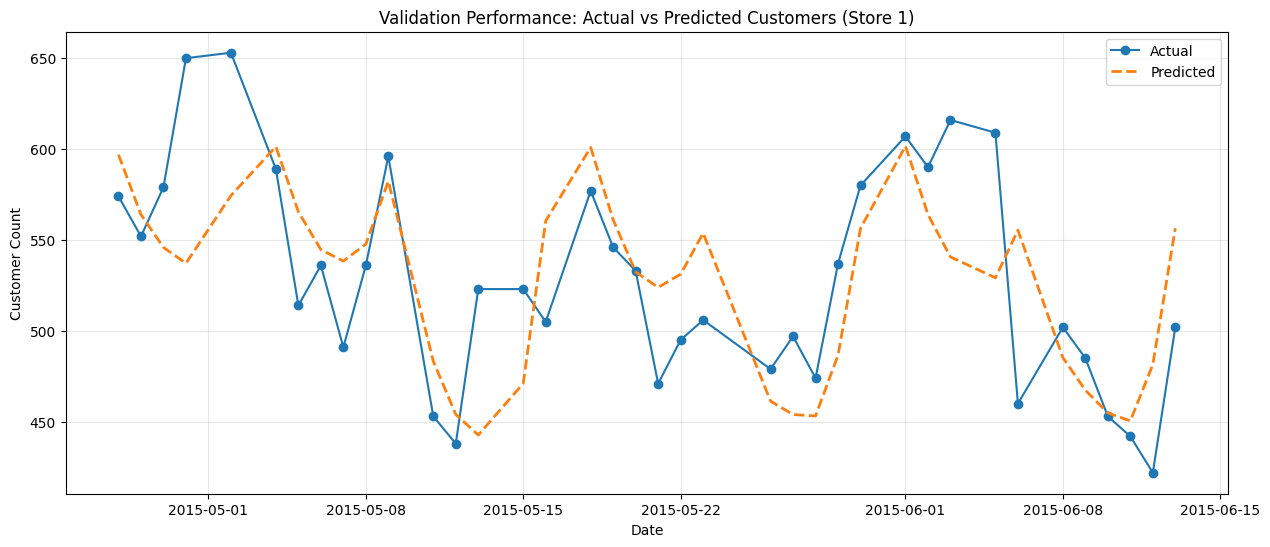

In [ ]:
import matplotlib.pyplot as plt

# 1. Define Model
parameters_cust = {
    "n_estimators": 200,
    "max_depth": 50,
    "max_samples": 0.6,
    "max_features": 0.5
}

model_cust = RandomForestRegressor(**parameters_cust, 
                                    n_jobs=10, # Use 4 to be safe with RAM
                                    random_state=42,
                                    verbose=0)

# 2. TRAIN on TRAINING DATA (Crucial!)
print("Training Customer Model...")
model_cust.fit(x_train_cust, y_train_cust)

# 3. PREDICT on VALIDATION DATA
print("Predicting on Validation Data...")
val_preds = model_cust.predict(x_val_cust) 

# 4. Prepare for Plotting
check_df = validation_set.copy()
check_df["Predicted_Customers"] = val_preds

# 5. Filter for ONE Store (e.g., Store 1)
# The validation set is short (6 weeks), so we view the whole thing for one store.
store_id = 1
plot_df = check_df[check_df["Store"] == store_id].sort_values("Date")

# 6. Plot
plt.figure(figsize=(15, 6))
plt.plot(plot_df["Date"], plot_df["Customers"], label="Actual", marker="o")
plt.plot(plot_df["Date"], plot_df["Predicted_Customers"], label="Predicted", linestyle="--", linewidth=2)

plt.title(f"Validation Performance: Actual vs Predicted Customers (Store {store_id})")
plt.xlabel("Date")
plt.ylabel("Customer Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()